In [1]:
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import numpy as np
import scipy.io as sio
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
import random
np.random.seed(0)
random.seed(0)






In [2]:

# cross-validation  with baseline include 0 class . accuracy =1- err  err=abs(y_pred-y_test)/3  

def valid(x,y,opt):
    if x.shape[1] == 15 :
        featureName=['VarBR','Varpp','VarIn','VarEx', 'meanBR',\
             'meanIn', 'meanEx' ,'r1 BR','r1 PP','r1 IN','r1 EX','r2 BR','r2 PP','r2 IN','r2 EX']
    if x.shape[1] == 18 :
        featureName=['CovBR','CovPP','CovIN','CovEX', 'meanBR',\
             'meanIN', 'meanEX' ,'r1 BR','r1 PP','r1 IN','r1 EX','r2 BR','r2 PP','r2 IN','r2 EX',\
            'meanHR','sdnn','rmsrr']
    thres=0.9
    acc=[]
    impt=[]
    scale=y[0,:]
    if y.shape[0] ==2:
      group=y[1,:]
      
    acc_max_temp=0  
    tree_max=[]
    a=opt[2]
    b=opt[3]
    ran=0
    if opt[0]=='kfold':
        rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=ran)

        
        for train_ind, test_ind in rkf.split(x,scale):
            #print("%s %s" % (train_ind, test_ind))
            #print(test_ind)
            X_train=x[train_ind] 
            X_test=x[test_ind]
            y_train=scale[train_ind] 
            y_test=scale[test_ind]
            
            acc_temp=np.zeros((8,))
            impt_temp=np.zeros((8,x.shape[1]))
            
            
            for i in range(8):
                if  opt[1]=='tree':
                    tree1 = DecisionTreeRegressor(max_depth=a,random_state=ran).fit(X_train,y_train)
                if  opt[1]=='forest':
                    tree1 = RandomForestRegressor(max_depth=b,n_estimators=40,max_features=None,random_state=ran).fit(X_train,y_train)

                y_p=tree1.predict(X_test)
                acc_t = 1-abs(y_p.astype('float')-y_test.astype('float'))/10
                
                acc_temp[i]=np.mean(acc_t)
                impt_temp[i,:]=tree1.feature_importances_
                if acc_temp[i] >= thres:
                    acc_max_temp=acc_temp[i]
                    tree_max.append(tree1)

            max=np.max(acc_temp)
            ind=np.where(acc_temp == np.amax(acc_temp))
            ind=np.min(ind)
            impt_max=impt_temp[ind,:]
            acc.append(max) 
            impt.append(impt_max)


    if opt[0]=='group':
        rkf = LeaveOneGroupOut()

        for train_ind, test_ind in rkf.split(x,scale,group):
            #print("%s %s" % (train_ind, test_ind))
            #print(test_ind)
            X_train=x[train_ind] 
            X_test=x[test_ind]
            y_train=scale[train_ind] 
            y_test=scale[test_ind]
            
            acc_temp=np.zeros((8,))
            impt_temp=np.zeros((8,x.shape[1]))
            
             
            for i in range(8):
                if  opt[1]=='tree':
                    tree1 = DecisionTreeRegressor(max_depth=a).fit(X_train,y_train)
                if  opt[1]=='forest':
                    tree1 = RandomForestRegressor(max_depth=b,n_estimators=40,max_features=None).fit(X_train,y_train)

                y_p=tree1.predict(X_test)
                acc_t = 1-abs(y_p.astype('float')-y_test.astype('float'))/10
                acc_temp[i]=np.mean(acc_t)
                impt_temp[i,:]=tree1.feature_importances_
                if acc_temp[i] >= thres:
                    acc_max_temp=acc_temp[i]
                    tree_max.append(tree1)

            max=np.max(acc_temp)
            ind=np.where(acc_temp == np.amax(acc_temp))
            ind=np.min(ind)
            impt_max=impt_temp[ind,:]
            acc.append(max) 
            impt.append(impt_max)

    impt=np.array(impt) 
    importance1=np.mean(impt,axis=0)
    seq=np.argsort(importance1)
    featureName=np.array(featureName)
    featureName1=featureName[seq]
    importance1=importance1[seq]
    importance1=np.flip(importance1)
    featureName1=np.flip(featureName1)
        
    acc=np.array(acc)
    acc_mean=np.mean(acc)
    print('{n:.3f}'.format(n=acc_mean))
    
    return acc_mean,featureName1,importance1,tree_max,acc_max_temp


In [3]:
def test(X_test,y_test,tree):
    acc_temp=[]
    acc_max_temp=0
    for i in range(len(tree)):
        
        y_p=tree[i].predict(X_test)
        acc_t = 1-abs(y_p.astype('float')-y_test.astype('float'))/10
        
        acc_temp.append(np.mean(acc_t))
        if np.mean(acc_t) >= acc_max_temp:
            acc_max_temp=np.mean(acc_t)
            tree_max=tree[i]
            tree_max_ind=i       
            y=np.stack((y_test, y_p))
    print('{n:.3f}'.format(n=acc_max_temp))
    return acc_max_temp,y,tree_max_ind    #y = test + predict labels

def test_vote(X_test,y_test,tree):
    
    y_p_temp = np.zeros((X_test.shape[0],len(tree)))
    y_p=np.zeros((X_test.shape[0],))
    for i in range(len(tree)):
        y_p_temp[:,i]=tree[i].predict(X_test)

    
    y_p=np.mean(y_p_temp,axis=1)
      
        
    
    #acc = 1-abs(y_p.astype('int')-y_test.astype('int'))/10
    acc = 1-abs(y_p.astype('float')-y_test.astype('float'))/10
    acc=np.mean(acc)
    y_p=np.round(y_p,decimals=2)
    print('{n:.3f}'.format(n=acc))
    y=np.stack((y_test, y_p))
    return acc,y    #y = test + predict labels

In [4]:
score13_n=np.array([4, 9 ,2, 2 ,4 ,3, 6 ,9, 3, 2, 1, 4, 5 ,8, 3])

score15_n=np.array([9, 5 ,3 ,5, 4 ,2 ,8 ,3, 1, 1, 4, 1 ,3, 2])
score11=np.zeros((15,))
score_wo=np.hstack((score13_n,score15_n))
score=np.hstack((score13_n,score15_n,score11))
score2=np.hstack((score,score))
score2_wo=np.hstack((score_wo,score_wo))
score_feat=np.hstack((score11,score13_n,score15_n))
score2_feat=np.hstack((score_feat,score_feat))

#score_test=np.array([3,3,5,8,8,6,4,3])
score_test=np.array([3,3,5,8,8,6,4,3,0,0,0,10,10,10,10])
#score_test=np.array([2,5,8,6,8,3,7,1,0,0,0,10,10,10,10])
score2_test=np.hstack((score_test,score_test))


In [5]:
ind2_3=np.stack((np.linspace(0,14,15),np.linspace(44,58,15)))
print(ind2_3)
ind2_5=np.stack((np.linspace(15,28,14),np.linspace(59,72,14)))
print(ind2_5)

[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
 [44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58.]]
[[15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.]
 [59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72.]]


In [6]:

# 18 features include ECG  include NCS and chest belt 
# generate the best decision tree with highest accuracy & calculate mean accuracy
data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_norm.mat")
delta_norm = data['delta2']
group_norm = data['group_norm'].ravel()
y1=np.stack((score2, group_norm))

data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_extreme_train.mat")
data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_extreme_train_mod.mat")
#data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_test.mat")
delta_Ncs_extreme = data['deltaNcs']
delta_Bio_extreme = data['deltaBio']
delta2_extreme=np.concatenate((delta_Ncs_extreme, delta_Bio_extreme),axis=0)
opt1=['kfold','tree',5,5]
opt2=['kfold','forest',7,7]

score_extreme=np.array([10,10,10,10,10,10,10,10,10,10])
score2_extreme=np.hstack((score_extreme,score_extreme))
group_extreme=np.array([2,2,3,3,4,4,5,5,6,6])
group2_extreme=np.hstack((group_extreme,group_extreme))
delta_norm_extreme=np.vstack([delta_norm,delta2_extreme])

y1=np.block([[score2,score2_extreme],[group_norm,group2_extreme]])

#acc1,feature1,importance1,tree1,accMax1=valid(delta_norm_extrem,y1,opt)
ind_3=np.linspace(0,14,15)
ind_5=np.linspace(15,28,14)
ind2_3=np.hstack((np.linspace(0,14,15),np.linspace(44,58,15)))
ind2_5=np.hstack((np.linspace(15,28,14),np.linspace(59,72,14)))
# (accuracy,featurenameRank,importanceRank,treeList,accOfTreeList)=valid(x,y,opt)  
# opt=['kfold','forest',max_depth_tree,max_depth_forest]
delta_norm_3=np.delete(delta_norm_extreme,ind2_5,axis=0)
y1_3=np.delete(y1,ind2_5,axis=1)
acc_t,feature_t,importance_t,tree_t,accMax_t=valid(delta_norm_3,y1_3,opt1)
acc_f,feature_f,importance_f,tree_f,accMax_f=valid(delta_norm_3,y1_3,opt2)


data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_test_with0_10.mat")
data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_test_with0_10_mod.mat")
#data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_test.mat")
delta_Ncs_test = data['deltaNcs']
delta_Bio_test = data['deltaBio']
delta2_test=np.concatenate((delta_Ncs_test, delta_Bio_test),axis=0)
#score_test= data['score_n'].ravel()
score2_test=np.stack((score_test, score_test)).ravel()

test_all=np.vstack((delta2_test,delta_norm_extreme[ind2_5.astype('int'),:]))
test_score_all=np.hstack((score2_test,score2[ind2_5.astype('int')]))

#(accuracy,y=[y_test, y_p])=test_vote(x_test,y_test,treeList)
acc_t,label_t=test_vote(test_all,test_score_all,tree_t)
acc_f,label_f=test_vote(test_all,test_score_all,tree_f)
print(test_all.shape)



0.976
0.942
0.784
0.811
(58, 18)


In [7]:
data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_Ncs_norm.mat")
delta_norm_Bio = data['deltaNcs']
delta_norm = data['deltaBio']
#scale_norm = data['scale_n'].ravel()
group_norm = data['group_norm'].ravel()
#y1=np.stack((scale_norm, group_norm))
y1=np.stack((score, group_norm))










In [26]:
# artificially add extrem cases (5) to training set
#data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_extreme_train.mat")
data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_extreme_train_mod.mat")
#data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_test.mat")
#delta_Ncs_extreme = data['deltaNcs']
delta_Ncs_extreme = data['deltaNcs']
delta_Bio_extreme = data['deltaBio']
delta2_extreme=np.concatenate((delta_Ncs_extreme, delta_Bio_extreme),axis=0)
score_extreme=np.array([10,10,10,10,10,10,10,10,10,10])
score2_extreme=np.hstack((score_extreme,score_extreme))
group_extreme=np.array([2,2,3,3,4,4,5,5,6,6])
group2_extreme=np.hstack((group_extreme,group_extreme))
delta_norm_extreme=np.vstack([delta_norm,delta_Ncs_extreme[:,0:15]])

y1=np.block([[score,score_extreme],[group_norm,group_extreme]])
opt1=['kfold','tree',7,7]
opt2=['kfold','forest',8,8]

ind_3=np.linspace(0,14,15)
ind_3=np.linspace(15,28,14)





delta_norm_3=np.delete(delta_norm_extreme[:,0:15],ind_3,axis=0)
y1_3=np.delete(y1,ind_3,axis=1)
acc_ncs_t,feature_ncs_t,importance_ncs_t,tree_ncs_t,accMax_ncs_t=valid(delta_norm_3,y1_3,opt1)
acc_ncs_f,feature_ncs_f,importance_ncs_f,tree_ncs_f,accMax_ncs_f=valid(delta_norm_3,y1_3,opt2)
print(delta_norm_3.shape)




#data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_test_with0_10.mat")
data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_test_with0_10_mod.mat")
#data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_test.mat")
delta_Ncs_test = data['deltaNcs']
delta_Bio_test = data['deltaBio']
#score_test=data['score_n'].ravel()
test_all=np.vstack((delta_Ncs_test[:,0:15],delta_norm_extreme[ind_3.astype('int')]))

test_score_all=np.hstack((score_test,score[ind_3.astype('int')]))
acc_ncs_t,label_ncs_t=test_vote(test_all[:,0:15],test_score_all,tree_ncs_t)
acc_ncs_f,label_ncs_f=test_vote(test_all[:,0:15],test_score_all,tree_ncs_f)
print(test_all.shape)
print(label_ncs_f)


0.850
0.868
(40, 15)
0.803
0.873
(29, 15)
[[ 2.    5.    8.    6.    8.    3.    7.    1.    0.    0.    0.   10.
  10.   10.   10.    9.    5.    3.    5.    4.    2.    8.    3.    1.
   1.    4.    1.    3.    2.  ]
 [ 2.78  5.55  4.38  4.85  7.58  5.5   5.8   1.15  1.52  0.7   1.45 10.
  10.   10.   10.    8.15  2.15  2.1   1.1   1.4   0.8   3.9   1.1   1.02
   0.78  2.72  1.32  1.65  0.68]]


In [25]:
##chest-belt only 

# artificially add extrem cases (5) to training set
#data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_extreme_train.mat")
data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_extreme_train_mod.mat")
#data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_test.mat")
#delta_Ncs_extreme = data['deltaNcs']
delta_Ncs_extreme = data['deltaNcs']
delta_Bio_extreme = data['deltaBio']

score_extreme=np.array([10,10,10,10,10,10,10,10,10,10])
score2_extreme=np.hstack((score_extreme,score_extreme))
group_extreme=np.array([2,2,3,3,4,4,5,5,6,6])

delta_norm_extreme_Bio=np.vstack([delta_norm_Bio,delta_Bio_extreme[:,0:15]])

y1=np.block([[score,score_extreme],[group_norm,group_extreme]])
opt1=['kfold','tree',5,5]
opt2=['kfold','forest',6,6]

ind_3=np.linspace(0,14,15)
ind_3=np.linspace(15,28,14)





delta_norm_3_Bio=np.delete(delta_norm_extreme_Bio[:,0:15],ind_3,axis=0)
y1_3=np.delete(y1,ind_3,axis=1)
acc_bio_t,feature_bio_t,importance_bio_t,tree_bio_t,accMax_bio_t=valid(delta_norm_3_Bio,y1_3,opt1)
acc_bio_f,feature_bio_f,importance_bio_f,tree_bio_f,accMax_bio_f=valid(delta_norm_3_Bio,y1_3,opt2)
print(delta_norm_3_Bio.shape)




#data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_test_with0_10.mat")
data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_test_with0_10_mod.mat")
#data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_test.mat")
delta_Ncs_test = data['deltaNcs']
delta_Bio_test = data['deltaBio']
#score_test=data['score_n'].ravel()
test_all=np.vstack((delta_Bio_test[:,0:15],delta_norm_extreme_Bio[ind_3.astype('int')]))

test_score_all=np.hstack((score_test,score[ind_3.astype('int')]))
acc_bio_t,label_bio_t=test_vote(test_all[:,0:15],test_score_all,tree_bio_t)
acc_bio_f,label_bio_f=test_vote(test_all[:,0:15],test_score_all,tree_bio_f)
print(test_all.shape)
print(label_bio_t)

0.849
0.868
(40, 15)
0.814
0.881
(29, 15)
[[ 2.  5.  8.  6.  8.  3.  7.  1.  0.  0.  0. 10. 10. 10. 10.  9.  5.  3.
   5.  4.  2.  8.  3.  1.  1.  4.  1.  3.  2.]
 [ 0.  0.  9.  9.  9.  2.  9.  3.  0.  0.  3. 10. 10. 10. 10.  9.  0.  3.
   0.  0.  0.  0.  2.  0.  0.  3.  0.  0.  0.]]


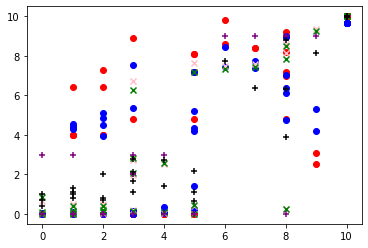

In [21]:
plt.scatter(label_t[0,:],label_t[1,:],marker='o', c='red',label="NCS+torso-belt+ECG decision tree")

plt.scatter(label_f[0,:],label_f[1,:],marker='o', c='blue',label="Luck")
plt.scatter(label_ncs_t[0,:],label_ncs_t[1,:],marker='x', c='pink')
plt.scatter(label_ncs_f[0,:],label_ncs_f[1,:],marker='x', c='green')
plt.scatter(label_bio_t[0,:],label_bio_t[1,:],marker='+', c='purple')
plt.scatter(label_bio_f[0,:],label_bio_f[1,:],marker='+', c='black')


from scipy.io import savemat
data = {"label_t_all": label_t, "label_f_all": label_t,"label_ncs_t": label_ncs_t, "label_ncs_f": label_ncs_f,"label_bio_t": label_bio_t, "label_bio_f": label_bio_f,}
#savemat(r"C:\Sleep test\dyspnea\data\python\scatter6_ind.mat", data)

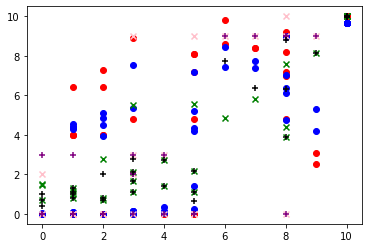

In [29]:
plt.scatter(label_t[0,:],label_t[1,:],marker='o', c='red',label="NCS+torso-belt+ECG decision tree")

plt.scatter(label_f[0,:],label_f[1,:],marker='o', c='blue',label="Luck")
plt.scatter(label_ncs_t[0,:],label_ncs_t[1,:],marker='x', c='pink')
plt.scatter(label_ncs_f[0,:],label_ncs_f[1,:],marker='x', c='green')
plt.scatter(label_bio_t[0,:],label_bio_t[1,:],marker='+', c='purple')
plt.scatter(label_bio_f[0,:],label_bio_f[1,:],marker='+', c='black')